## Customer Churn Case-Study Project

### Customer churn with Logistic Regression
A telecommunications company is concerned about the number of customers leaving their land-line business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

Machine learning algorithm - Logistic Regression is to find the best parameters θ, for ℎ_θ(𝑥) = 𝜎({θ^TX})

In [1]:
# import the needed libraries
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

### About the dataset
We’ll use a telecommunications data for predicting customer churn. This is a historical customer data where each row represents one customer. The data is relatively easy to understand, and we're able to uncover insights we can use immediately. Typically it’s less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company. 

Telco churn data ("ChurnData.csv) is a hypothetical data file that concerns a telecommunications company's efforts to reduce turnover in its customer base. Each case corresponds to a separate customer and it records various demographic and service usage information.

We predict behavior to retain customers by using the dataset. We can also analyze all relevant customer data and develop focused customer retention programs.


### Load Data From CSV File  

In [27]:
churn_df = pd.read_csv("ChurnData.csv")     # delim_whitespace=True)
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


In [28]:
churn_df.custcat.unique()

array([4., 1., 3., 2.])

In [29]:
churn_df['custcat'].dtype

dtype('float64')

### Data pre-processing and selection

Lets select some features for the modeling. Also we change the target data type to be integer, as it is a requirement  by the skitlearn algorithm:

In [30]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


In [31]:
churn_df.corr()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
tenure,1.000000,0.431802,0.456328,0.109383,-0.070503,0.445755,-0.117102,0.426530,-0.070590,-0.376860
age,0.431802,1.000000,0.746566,0.211275,-0.071509,0.622553,-0.071357,0.170404,-0.065527,-0.287697
address,0.456328,0.746566,1.000000,0.132807,-0.145550,0.520926,-0.148977,0.209204,-0.146478,-0.260659
income,0.109383,0.211275,0.132807,1.000000,0.141241,0.345161,-0.010741,-0.019969,-0.029635,-0.090790
ed,-0.070503,-0.071509,-0.145550,0.141241,1.000000,-0.213886,0.488041,-0.071178,0.267670,0.216112
employ,0.445755,0.622553,0.520926,0.345161,-0.213886,1.000000,-0.174470,0.266612,-0.101187,-0.337969
equip,-0.117102,-0.071357,-0.148977,-0.010741,0.488041,-0.174470,1.000000,-0.087051,0.386735,0.275284
callcard,0.426530,0.170404,0.209204,-0.019969,-0.071178,0.266612,-0.087051,1.000000,0.220118,-0.311451
wireless,-0.070590,-0.065527,-0.146478,-0.029635,0.267670,-0.101187,0.386735,0.220118,1.000000,0.174356
churn,-0.376860,-0.287697,-0.260659,-0.090790,0.216112,-0.337969,0.275284,-0.311451,0.174356,1.000000


Lets define X, and y for our dataset:

In [32]:
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
X[0:5]

array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
       [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
       [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
       [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
       [  7.,  35.,  14.,  80.,   2.,  15.,   0.]])

In [33]:
y = np.asarray(churn_df['churn'])
y [0:5]

array([1, 1, 0, 0, 0])

Also, we normalize the dataset:

In [34]:
from sklearn import preprocessing        

X = preprocessing.StandardScaler().fit(X).transform(X)    
X[0:5]

array([[-1.14, -0.63, -0.46,  0.48,  1.7 , -0.58, -0.86],
       [-0.12, -0.63,  0.03, -0.33, -0.64, -1.14, -0.86],
       [-0.58, -0.86, -0.26, -0.35, -1.42, -0.92, -0.86],
       [ 0.12, -0.47, -0.66,  0.01, -0.64, -0.03,  1.16],
       [-1.32, -0.47,  0.23,  0.04, -0.64,  0.53, -0.86]])

We now split our dataset into train and test set:

In [35]:
# non-linearRegression data split...
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)     ##...test = 0.2...
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 7) (160,)
Test set: (40, 7) (40,)


### Modeling  

Let's build our model using LogisticRegression from Scikit-learn package. 

In [36]:
##... C parameter indicates inverse of regularization strength which must be a positive float. 
      ##   Smaller values specify stronger regularization.

from sklearn.linear_model import LogisticRegression      
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)      
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### Predicttion

Now we can predict using our test set:

In [37]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

### Evaluation 1

"predict_proba" returns estimates for all classes, ordered by the label of classes. Thus, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):

In [38]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[:15]

array([[0.54, 0.46],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.63, 0.37],
       [0.56, 0.44],
       [0.55, 0.45],
       [0.52, 0.48],
       [0.61, 0.39],
       [0.41, 0.59],
       [0.63, 0.37],
       [0.58, 0.42],
       [0.63, 0.37],
       [0.48, 0.52],
       [0.43, 0.57],
       [0.66, 0.34]])

### Evaluation 2

Let's use jaccard index for accuracy evaluation as another method. We may define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.



In [39]:
##...jaccard....
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.75

### Evaluation 3

Another way of looking at accuracy of classifier is to look at Confusion Matrix.

In [40]:
from sklearn.metrics import classification_report, confusion_matrix         
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 6  9]
 [ 1 24]]


Confusion matrix, without normalization
[[ 6  9]
 [ 1 24]]


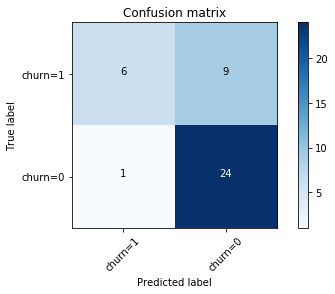

In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

Look at first row. The firsr row is for customers whose actual churn value in test set is 1.
As you can calculate, out of 40 customers, the churn value of 15 of them is 1. 
And out of these 15, the classifier correctly predicted 6 of them as 1, and 9 of them as 0. 

It means, for 6 customers, the actual churn value were 1 in test set, and classifier also correctly predicted those as 1. However, while the actual label of 9 customers were 1, the classifier predicted those as 0, which is not very good. We can consider it as error of the model for first row.

What about the customers with churn value 0? Lets look at the second row.
It looks like  there were 25 customers whom their churn value were 0. 


The classifier correctly predicted 24 of them as 0, and one of them wrongly as 1. So, it has done a good job in predicting the customers with churn value 0. A good thing about confusion matrix is that shows the model’s ability to correctly predict or separate the classes.  In specific case of binary classifier, such as this example,  we can interpret these numbers as the count of true positives, false positives, true negatives, and false negatives. 

In [17]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.73      0.96      0.83        25
           1       0.86      0.40      0.55        15

   micro avg       0.75      0.75      0.75        40
   macro avg       0.79      0.68      0.69        40
weighted avg       0.78      0.75      0.72        40



precision = TP / (TP + FP);
recall =  TP / (TP + FN)

The F1score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

### Evaluation 4

Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1. 


In [18]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)     

0.6017092478101187